# 🎓 MenaML: Distillation Workshop

**Author:** [Your Name]  
**Date:** 2026

---

## Learning Objectives

By the end of this workshop, you will:
1. Understand the core concepts behind Distillation
2. Implement a Teacher-Student training framework from scratch
3. Compare different training strategies: baseline, hard labels, soft labels
4. Analyze the trade-offs between model size and performance

---

## 1. Introduction: What is Knowledge Distillation?

**Knowledge Distillation** is a technique whereby a student neural network learns from another, usually already pre-trained neural network. KD can be used for compressing the model, in which case the student is smaller. It can also be used for improving model performance, where the student is the same or even larger than the teacher. In either case, the the student is trained to mimic the behavior of one or more teacher models.

### Why do we need it?

- **Deployment constraints**: Large models are expensive to run on edge devices, mobile phones, or in real-time applications
- **Inference speed**: Smaller models are faster
- **Cost reduction**: Less compute = less money and energy
- **Increased performance**: Sometimes KD is used to increase the performance of our model.

## Why Does KD work?

### The "Dark Knowledge"

In their seminal 2015 paper, Hinton et al. observed that the **soft probability outputs** of a teacher model contain more information than hard labels.

**Example**: For a cat image, hard label says `[0, 0, 1, 0, ...]` (just "cat")  
But soft labels might say `[0.01, 0.05, 0.85, 0.09, ...]` revealing that the image also looks a bit like a dog or tiger!

This extra information about class relationships is the "dark knowledge" that helps the student learn better.

![Distillation Diagram](https://intellabs.github.io/distiller/imgs/knowledge_distillation.png)


### Reweighing Training Examples

Even if we ignore probabilities for all classes other than the true class, we get an effect where some examples are weighted higher than other ones according to what probability the teacher assigns to the true class. [] showed that this *importance weighing* is an important component of how KD works.

## 2. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


## 3. Dataset: CIFAR-10

We'll use CIFAR-10: 60,000 32x32 color images in 10 classes.

In [2]:
# Data augmentation and normalization
cifar_mean = np.asarray([0.4914, 0.4822, 0.4465])
cifar_std = np.asarray([0.2023, 0.1994, 0.2010])
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std),
])

# Download and load datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")

100%|██████████| 170M/170M [00:14<00:00, 11.5MB/s]


Training samples: 50000
Test samples: 10000


/tmp/ipython-input-3971349199.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = img * cifar_std[:, None, None] + cifar_mean[:, None, None]


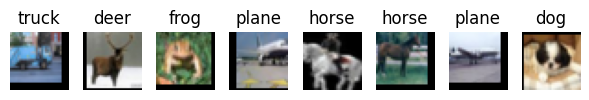

In [3]:
# Visualize some samples
def imshow(ax, img):
    img = img * cifar_std[:, None, None] + cifar_mean[:, None, None]
    img = np.clip(img, 0., 1.)
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
fig, axes = plt.subplots(1, 8, figsize=(6, 1))
for i in range(8):
    # axes[i].imshow(np.transpose((images[i] / 2 + 0.5).numpy(), (1, 2, 0)))
    imshow(axes[i], images[i])
    axes[i].set_title(classes[labels[i]])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## 4. Model Definitions

### Teacher Model: ResNet-18 (11M parameters)
### Student Model: Small CNN (< 1M parameters)

The goal is to transfer knowledge from the large teacher to the tiny student.

In [4]:
class TeacherCNN(nn.Module):
    """
    Teacher: ResNet-18 adapted for CIFAR-10 (32x32 images)
    """
    def __init__(self, num_classes=10, weights='IMAGENET1K_V1'):
        super(TeacherCNN, self).__init__()
        self.model = models.resnet18(weights=weights)
        # Modify first conv layer for 32x32 images (no aggressive downsampling)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()  # Remove maxpool for small images
        self.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model.fc = nn.Identity()

    def forward(self, x, output_features=False):
        x = self.model(x)
        logits = self.fc(x)
        if output_features:
            return logits, x
        return logits

def get_teacher_model(num_classes=10, weights=None):
    """
    Teacher: ResNet-18 adapted for CIFAR-10 (32x32 images)
    """
    model = TeacherCNN(num_classes=num_classes, weights=weights)
    return model


class StudentCNN(nn.Module):
    """
    Student: A small CNN with ~100K parameters
    """
    def __init__(self, num_classes=10, output_dim=256):
        super(StudentCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32 -> 16

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16 -> 8

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 8 -> 4

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 4 -> 2

            # Block 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 2 -> 1
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 1 * 1, output_dim),  # 512 to match teacher
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(output_dim, num_classes),
        )

    def forward(self, x, output_features=False):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        logits = self.fc2(x)
        if output_features:
            return logits, x
        return logits


def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Activity 1. Instantiate the Teacher and Student models

In [ ]:
# TODO
teacher = None
student = None

#### Solution

In [5]:
# Create models and compare sizes
teacher = get_teacher_model(weights='IMAGENET1K_V1').to(device)
student = StudentCNN().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 221MB/s]


### Compare Student and Teacher Model Sizes

In [6]:
teacher_params = count_parameters(teacher)
student_params = count_parameters(student)

print(f"Teacher (ResNet-18) parameters: {teacher_params:,}")
print(f"Student (Small CNN) parameters: {student_params:,}")
print(f"\nCompression ratio: {teacher_params / student_params:.1f}x smaller")

Teacher (ResNet-18) parameters: 11,173,962
Student (Small CNN) parameters: 1,704,458

Compression ratio: 6.6x smaller


## 5. Training Utilities

In [7]:
def train_epoch(model, trainloader, criterion, optimizer, device):
    """Train for one epoch (standard training)"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(trainloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(trainloader), 100. * correct / total


def evaluate(model, testloader, device):
    """Evaluate model on test set"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total

## 6. Train the Teacher Model

First, we need a well-trained teacher. In practice, you might use a pre-trained model, but we'll train one from scratch for educational purposes.

**Note**: To save time, we'll provide the checkpoint, but you can check the training code and train your own teacher later.

### 6.1. Download the Teacher Model

In [8]:
!gdown --id 1Ko41G-TVerBr1tY0cSr4m1h1s9PvHRXw

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Ko41G-TVerBr1tY0cSr4m1h1s9PvHRXw
From (redirected): https://drive.google.com/uc?id=1Ko41G-TVerBr1tY0cSr4m1h1s9PvHRXw&confirm=t&uuid=575c6478-9de6-4468-a154-01feebde1374
To: /content/teacher_resnet18.pth
100% 44.8M/44.8M [00:01<00:00, 25.9MB/s]


### 6.2. Train the Teacher Model

In [ ]:
# Training configuration
TEACHER_EPOCHS = 15  # Increase for better teacher (50+ recommended)
LEARNING_RATE = 0.01

teacher = get_teacher_model(weights='IMAGENET1K_V1').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TEACHER_EPOCHS)

print("Training Teacher Model (ResNet-18)...")
print("=" * 50)

teacher_history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

best_test_acc = 0.0
for epoch in range(TEACHER_EPOCHS):
    train_start = time.time()
    train_loss, train_acc = train_epoch(teacher, trainloader, criterion, optimizer, device)
    train_time = time.time() - train_start
    eval_start = time.time()
    test_acc = evaluate(teacher, testloader, device)
    eval_time = time.time() - eval_start
    scheduler.step()

    teacher_history['train_loss'].append(train_loss)
    teacher_history['train_acc'].append(train_acc)
    teacher_history['test_acc'].append(test_acc)

    print(
        f"Epoch {epoch+1:2d}/{TEACHER_EPOCHS} | Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Epoch time "
        f"{train_time:.2f}s | Eval time {eval_time:.2f}s"
    )
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        # Save teacher model
        torch.save(teacher.state_dict(), 'teacher_resnet18.pth')

print(f"\n✅ Teacher final test accuracy: {best_test_acc:.2f}%")

Training Teacher Model (ResNet-18)...


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  1/15 | Loss: 0.8110 | Train Acc: 71.69% | Test Acc: 82.10%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  2/15 | Loss: 0.3855 | Train Acc: 86.63% | Test Acc: 87.25%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  3/15 | Loss: 0.2848 | Train Acc: 90.17% | Test Acc: 88.86%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  4/15 | Loss: 0.2208 | Train Acc: 92.31% | Test Acc: 90.61%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  5/15 | Loss: 0.1772 | Train Acc: 93.91% | Test Acc: 92.12%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  6/15 | Loss: 0.1398 | Train Acc: 95.11% | Test Acc: 91.90%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  7/15 | Loss: 0.1128 | Train Acc: 96.12% | Test Acc: 92.48%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  8/15 | Loss: 0.0897 | Train Acc: 97.00% | Test Acc: 92.90%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  9/15 | Loss: 0.0701 | Train Acc: 97.64% | Test Acc: 93.21%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/15 | Loss: 0.0533 | Train Acc: 98.16% | Test Acc: 93.61%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/15 | Loss: 0.0408 | Train Acc: 98.70% | Test Acc: 93.81%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/15 | Loss: 0.0309 | Train Acc: 99.03% | Test Acc: 93.98%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/15 | Loss: 0.0281 | Train Acc: 99.12% | Test Acc: 94.09%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/15 | Loss: 0.0257 | Train Acc: 99.24% | Test Acc: 94.07%


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/15 | Loss: 0.0220 | Train Acc: 99.38% | Test Acc: 94.18%

✅ Teacher final test accuracy: 94.18%


## 7. The Core: Knowledge Distillation Loss

### The Distillation Loss Function
The key innovation is combining two losses:
$$L_{total} = \alpha \cdot L_{hard} + (1 - \alpha) \cdot L_{soft}$$
Where:
- $L_{hard}$ = Cross-entropy with true labels (standard supervised loss)
- $L_{soft}$ = KL divergence between teacher and student soft predictions
- $\alpha$ = Weight balancing the two losses (typically 0.1-0.5)

### Activity 2. Implement the `DistillationLoss` class in accordance with the previously provided description.



In [ ]:
class DistillationLoss(nn.Module):
    """
    Knowledge Distillation Loss

    Combines:
    1. Hard label loss: classification cross entropy.
    2. Soft label loss: KL divergence between the student and teacher logits.

    The T^2 factor compensates for the gradient magnitude reduction when using temperature.
    """
    def __init__(self, alpha=0.3):
        super().__init__()
        # TODO
    def forward(self, student_logits, teacher_logits, labels):
        # TODO
        return total_loss, hard_loss, soft_loss

#### Solution

In [9]:
class DistillationLoss(nn.Module):
    """
    Knowledge Distillation Loss

    Combines:
    1. Hard label loss: CrossEntropy(student_output, true_labels)
    2. Soft label loss: KLDiv(student_soft, teacher_soft) * T^2

    The T^2 factor compensates for the gradient magnitude reduction when using temperature.
    """
    def __init__(self, alpha=0.3):
        super().__init__()
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits, teacher_logits, labels):
        # Hard label loss (standard cross-entropy)
        hard_loss = self.ce_loss(student_logits, labels)

        # Soft label loss (KL divergence)
        # Student: log-softmax
        student_logits = F.log_softmax(student_logits, dim=1)
        # Teacher: softmax (target distribution)
        teacher_probs = F.softmax(teacher_logits, dim=1)

        # KL divergence * T^2 (to match gradient magnitude)
        soft_loss = self.kl_loss(student_logits, teacher_probs)

        # Combined loss
        total_loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

        return total_loss, hard_loss, soft_loss

## 8. Train Student with Distillation

### Activity 3. Complete the knowledge distillation training loop.

In [10]:
def train_with_distillation(student, teacher, trainloader, criterion, optimizer, device):
    """
    Train student using knowledge distillation from teacher.
    Teacher is frozen (no gradients).
    """
    student.train()
    # TODO: Teacher is always in eval mode

    running_loss = 0.0
    running_hard_loss = 0.0
    running_soft_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(trainloader, desc="Distilling", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # TODO: Get teacher predictions (no gradient needed)

        # Forward pass for student
        optimizer.zero_grad()
        student_logits = student(inputs)

        # TODO: Compute distillation loss

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        running_hard_loss += hard_loss.item()
        running_soft_loss += soft_loss.item()
        _, predicted = student_logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    n = len(trainloader)
    return running_loss/n, running_hard_loss/n, running_soft_loss/n, 100.*correct/total

#### Solution

In [11]:
def train_with_distillation(student, teacher, trainloader, criterion, optimizer, device):
    """
    Train student using knowledge distillation from teacher.
    Teacher is frozen (no gradients).
    """
    student.train()
    teacher.eval()  # Teacher is always in eval mode

    running_loss = 0.0
    running_hard_loss = 0.0
    running_soft_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(trainloader, desc="Distilling", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # Get teacher predictions (no gradient needed)
        with torch.no_grad():
            teacher_logits = teacher(inputs)

        # Forward pass for student
        optimizer.zero_grad()
        student_logits = student(inputs)

        # Compute distillation loss
        loss, hard_loss, soft_loss = criterion(student_logits, teacher_logits, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        running_hard_loss += hard_loss.item()
        running_soft_loss += soft_loss.item()
        _, predicted = student_logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    n = len(trainloader)
    return running_loss/n, running_hard_loss/n, running_soft_loss/n, 100.*correct/total

### Training with distillation (Using big network as teacher)

In [12]:
# Distillation configuration
STUDENT_EPOCHS = 5
ALPHA = 0.1        # Weight for hard loss (try: 0.1, 0.3, 0.5)
LR = 0.01

# Load trained teacher
teacher.load_state_dict(torch.load('teacher_resnet18.pth'))
teacher.eval()

teacher_dim = teacher.fc.in_features
student_distilled = StudentCNN(output_dim=teacher_dim).to(device)

# Setup training
distill_criterion = DistillationLoss(alpha=ALPHA)
optimizer = optim.Adam(student_distilled.parameters(), lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STUDENT_EPOCHS, eta_min=0.001)

print(f"Training Student with Knowledge Distillation")
print(f"Alpha: {ALPHA}")
print("=" * 60)

distilled_history = {'total_loss': [], 'hard_loss': [], 'soft_loss': [], 'train_acc': [], 'test_acc': []}

best_test_acc = 0.0
for epoch in range(STUDENT_EPOCHS):
    train_start = time.time()
    total_loss, hard_loss, soft_loss, train_acc = train_with_distillation(
        student_distilled, teacher, trainloader, distill_criterion, optimizer, device
    )
    train_time = time.time() - train_start
    eval_start = time.time()
    test_acc = evaluate(student_distilled, testloader, device)
    eval_time = time.time() - eval_start
    scheduler.step()

    distilled_history['total_loss'].append(total_loss)
    distilled_history['hard_loss'].append(hard_loss)
    distilled_history['soft_loss'].append(soft_loss)
    distilled_history['train_acc'].append(train_acc)
    distilled_history['test_acc'].append(test_acc)

    print(
        f"Epoch {epoch+1:2d}/{STUDENT_EPOCHS} | Loss: {total_loss:.4f} "
        f"(H:{hard_loss:.3f} S:{soft_loss:.3f}) | "
        f"Train: {train_acc:.2f}% | Test: {test_acc:.2f}% |"
        f" Epoch time {train_time:.2f}s | Eval time {eval_time:.2f}s"
    )

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(student_distilled.state_dict(), 'student_distilled_v1.pth')
print(f"\n✅ Distilled Student final test accuracy: {best_test_acc:.2f}%")

Training Student with Knowledge Distillation
Alpha: 0.1


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  1/5 | Loss: 2.0996 (H:2.128 S:2.096) | Train: 17.59% | Test: 20.25% | Epoch time 23.15s | Eval time 2.33s


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  2/5 | Loss: 1.8844 (H:1.913 S:1.881) | Train: 23.24% | Test: 30.13% | Epoch time 21.49s | Eval time 2.31s


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  3/5 | Loss: 1.6389 (H:1.667 S:1.636) | Train: 35.76% | Test: 43.01% | Epoch time 21.76s | Eval time 2.29s


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  4/5 | Loss: 1.3335 (H:1.362 S:1.330) | Train: 50.17% | Test: 58.74% | Epoch time 21.73s | Eval time 2.29s


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  5/5 | Loss: 1.1148 (H:1.143 S:1.112) | Train: 60.24% | Test: 66.08% | Epoch time 21.82s | Eval time 2.32s

✅ Distilled Student final test accuracy: 66.08%


## 9. Baseline: Train Student WITHOUT Distillation

To appreciate the value of distillation, let's train the same student architecture with only hard labels.

In [13]:
# Train student from scratch (no teacher)
teacher_dim = teacher.fc.in_features
student_baseline = StudentCNN(output_dim=teacher_dim).to(device)
criterion_baseline = nn.CrossEntropyLoss()
optimizer_baseline = optim.Adam(student_baseline.parameters(), lr=0.01)
scheduler_baseline = optim.lr_scheduler.CosineAnnealingLR(optimizer_baseline, T_max=STUDENT_EPOCHS, eta_min=0.001)

print("Training Student Baseline (NO distillation)...")
print("=" * 50)

baseline_history = {'train_loss': [], 'train_acc': [], 'test_acc': []}
best_test_acc = 0.0

for epoch in range(STUDENT_EPOCHS):
    train_start = time.time()
    train_loss, train_acc = train_epoch(student_baseline, trainloader, criterion_baseline, optimizer_baseline, device)
    train_time = time.time() - train_start
    eval_start = time.time()
    test_acc = evaluate(student_baseline, testloader, device)
    eval_time = time.time() - eval_start
    scheduler.step()

    baseline_history['train_loss'].append(train_loss)
    baseline_history['train_acc'].append(train_acc)
    baseline_history['test_acc'].append(test_acc)

    print(
        f"Epoch {epoch+1:2d}/{STUDENT_EPOCHS} | Loss: {train_loss:.4f} "
        f"Train: {train_acc:.2f}% | Test: {test_acc:.2f}% |"
        f" Epoch time {train_time:.2f}s | Eval time {eval_time:.2f}s"
    )

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(student_baseline.state_dict(), 'student_baseline.pth')
print(f"\n✅ Baseline Student final test accuracy: {best_test_acc:.2f}%")

Training Student Baseline (NO distillation)...


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  1/5 | Loss: 2.1406 Train: 17.87% | Test: 24.93% | Epoch time 20.39s | Eval time 2.34s


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  2/5 | Loss: 1.8950 Train: 25.03% | Test: 32.35% | Epoch time 20.34s | Eval time 2.27s


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  3/5 | Loss: 1.6407 Train: 37.76% | Test: 40.46% | Epoch time 20.45s | Eval time 2.24s


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  4/5 | Loss: 1.4387 Train: 47.33% | Test: 49.59% | Epoch time 20.38s | Eval time 2.28s


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  5/5 | Loss: 1.2953 Train: 54.55% | Test: 61.78% | Epoch time 20.26s | Eval time 2.30s

✅ Baseline Student final test accuracy: 61.78%


## 10. Results Comparison

In [14]:
# Final comparison
teacher_acc = evaluate(teacher, testloader, device)
distilled_acc = evaluate(student_distilled, testloader, device)
baseline_acc = evaluate(student_baseline, testloader, device)

print("\n" + "="*60)
print("📊 FINAL RESULTS")
print("="*60)
print(f"{'Model':<25} {'Parameters':<15} {'Test Accuracy':<15}")
print("-"*60)
print(f"{'Teacher (ResNet-18)':<25} {teacher_params:>12,} {teacher_acc:>12.2f}%")
print(f"{'Student (Baseline)':<25} {student_params:>12,} {baseline_acc:>12.2f}%")
print(f"{'Student (Distilled)':<25} {student_params:>12,} {distilled_acc:>12.2f}%")
print("-"*60)
print(f"\n📈 Distillation improvement: +{distilled_acc - baseline_acc:.2f}%")
print(f"🗜️  Compression ratio: {teacher_params / student_params:.1f}x fewer parameters")


📊 FINAL RESULTS
Model                     Parameters      Test Accuracy  
------------------------------------------------------------
Teacher (ResNet-18)         11,173,962        94.55%
Student (Baseline)           1,704,458        61.78%
Student (Distilled)          1,704,458        66.08%
------------------------------------------------------------

📈 Distillation improvement: +4.30%
🗜️  Compression ratio: 6.6x fewer parameters


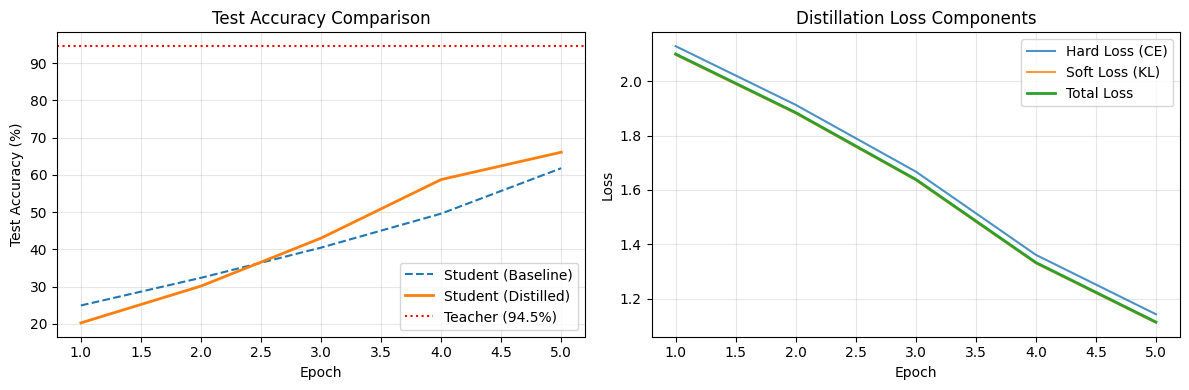

In [26]:
#@title Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

xs = np.arange(1, STUDENT_EPOCHS + 1)
# Test accuracy comparison
axes[0].plot(xs, baseline_history['test_acc'], label='Student (Baseline)', linestyle='--')
axes[0].plot(xs, distilled_history['test_acc'], label='Student (Distilled)', linewidth=2)
axes[0].axhline(y=teacher_acc, color='r', linestyle=':', label=f'Teacher ({teacher_acc:.1f}%)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('Test Accuracy Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss breakdown for distilled student
axes[1].plot(xs, distilled_history['hard_loss'], label='Hard Loss (CE)', alpha=0.8)
axes[1].plot(xs, distilled_history['soft_loss'], label='Soft Loss (KL)', alpha=0.8)
axes[1].plot(xs, distilled_history['total_loss'], label='Total Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Distillation Loss Components')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Inference Speed Comparison

In [16]:
def benchmark_inference(model, input_size=(1, 3, 32, 32), num_iterations=1000):
    """Benchmark inference speed"""
    model.eval()
    dummy_input = torch.randn(input_size).to(device)

    # Warmup
    for _ in range(100):
        with torch.no_grad():
            _ = model(dummy_input)

    # Benchmark
    if device.type == 'cuda':
        torch.cuda.synchronize()

    start = time.time()
    for _ in range(num_iterations):
        with torch.no_grad():
            _ = model(dummy_input)

    if device.type == 'cuda':
        torch.cuda.synchronize()

    elapsed = time.time() - start
    return elapsed / num_iterations * 1000  # ms per inference

teacher_time = benchmark_inference(teacher)
student_time = benchmark_inference(student_distilled)

print("\n⚡ Inference Speed (single sample)")
print("-" * 40)
print(f"Teacher (ResNet-18): {teacher_time:.3f} ms")
print(f"Student (Distilled): {student_time:.3f} ms")
print(f"Speedup: {teacher_time / student_time:.2f}x faster")


⚡ Inference Speed (single sample)
----------------------------------------
Teacher (ResNet-18): 2.464 ms
Student (Distilled): 0.924 ms
Speedup: 2.67x faster


## 12. Temperature Scaling
We "soften" the probability distributions using temperature $T$:
$$p_i = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}$$
- $T = 1$: Normal softmax
- $T > 1$: Softer distribution (reveals more information about class relationships)
- Typically $T \in [3, 20]$

Note that the temperature is applied to both the teacher and the student outputs.
As the temperature T increases, the gradient of the loss gets rescaled by a factor of (1/T)^2. This has been derived in the original Hinton paper. As decreasing gradient value can affect optimization dynamics, we need to upscale the gradients by a factor of T^2. The easiest way to do it is just to multiply the loss by T^2.

### 🔍 Let's Visualize Temperature Effects

Understanding how temperature affects the probability distribution is crucial.

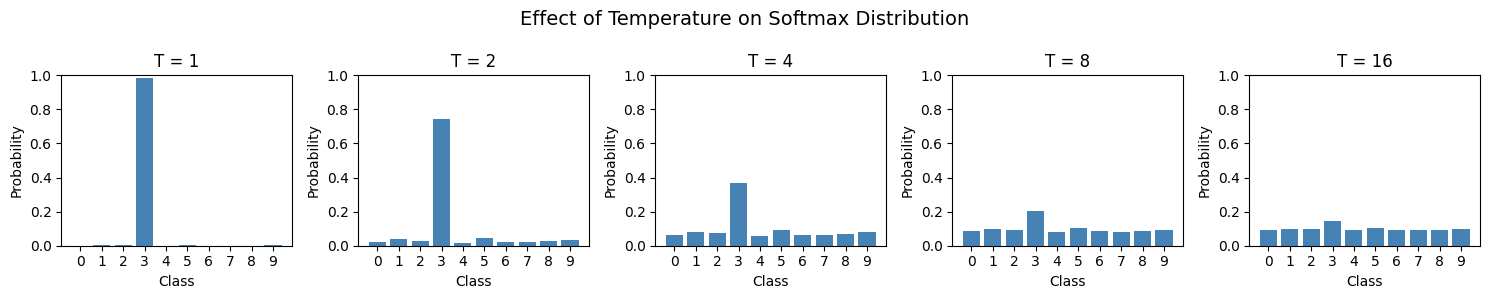


📊 Observation:
- T=1: Sharp distribution (almost one-hot)
- T>1: Softer distribution revealing class relationships
- Higher T = more 'dark knowledge' transferred


In [17]:
# Demonstrate temperature effect
def visualize_temperature_effect(logits, temperatures=[1, 2, 4, 8, 16]):
    fig, axes = plt.subplots(1, len(temperatures), figsize=(15, 3))

    for ax, T in zip(axes, temperatures):
        probs = F.softmax(logits / T, dim=0).numpy()
        ax.bar(range(len(probs)), probs, color='steelblue')
        ax.set_title(f'T = {T}')
        ax.set_xlabel('Class')
        ax.set_ylabel('Probability')
        ax.set_ylim(0, 1)
        ax.set_xticks(range(10))

    plt.suptitle('Effect of Temperature on Softmax Distribution', fontsize=14)
    plt.tight_layout()
    plt.show()

# Example logits (model is quite confident about class 3)
example_logits = torch.tensor([1.0, 2.0, 1.5, 8.0, 0.5, 2.5, 1.0, 0.8, 1.2, 1.8])
visualize_temperature_effect(example_logits)

print("\n📊 Observation:")
print("- T=1: Sharp distribution (almost one-hot)")
print("- T>1: Softer distribution revealing class relationships")
print("- Higher T = more 'dark knowledge' transferred")

### Activity 4. Implement the `TemperedDistillationLoss` class.
It should be similar to `DistillationLoss` but with the temperature scaling applied to the teacher and student probabilities, and rescaled loss.



In [19]:
class TemperedDistillationLoss(nn.Module):
    """
    Knowledge Distillation Loss

    Combines:
    1. Hard label loss: CrossEntropy(student_output, true_labels)
    2. Soft label loss: KLDiv(student_soft, teacher_soft) * T^2

    The T^2 factor compensates for the gradient magnitude reduction when using temperature.
    """
    def __init__(self, temperature=4.0, alpha=0.3):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits, teacher_logits, labels):
        # Hard label loss (standard cross-entropy)
        hard_loss = self.ce_loss(student_logits, labels)

        # TODO: student_soft and teacher_soft with temperature scaling.
        student_soft = None
        teacher_soft = None

        # KL divergence * T^2 (to match gradient magnitude)
        soft_loss = self.kl_loss(student_soft, teacher_soft) * (self.temperature ** 2)

        # Combined loss
        total_loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

        return total_loss, hard_loss, soft_loss

#### Solution

In [20]:
class TemperedDistillationLoss(nn.Module):
    """
    Knowledge Distillation Loss

    Combines:
    1. Hard label loss: CrossEntropy(student_output, true_labels)
    2. Soft label loss: KLDiv(student_soft, teacher_soft) * T^2

    The T^2 factor compensates for the gradient magnitude reduction when using temperature.
    """
    def __init__(self, temperature=4.0, alpha=0.3):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits, teacher_logits, labels):
        # Hard label loss (standard cross-entropy)
        hard_loss = self.ce_loss(student_logits, labels)

        # Soft label loss (KL divergence with temperature)
        # Student: log-softmax with temperature
        student_soft = F.log_softmax(student_logits / self.temperature, dim=1)
        # Teacher: softmax with temperature (target distribution)
        teacher_soft = F.softmax(teacher_logits / self.temperature, dim=1)

        # KL divergence * T^2 (to match gradient magnitude)
        soft_loss = self.kl_loss(student_soft, teacher_soft) * (self.temperature ** 2)

        # Combined loss
        total_loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss

        return total_loss, hard_loss, soft_loss

### Training with temperature-scaled distillation (Using big network as teacher)

In [21]:
# Distillation configuration
ALPHA = 0.1        # Weight for hard loss (try: 0.1, 0.3, 0.5)
TEMPERATURE = 4.0  # Try values in [1, 20]
LR = 0.01

# Load trained teacher
teacher.load_state_dict(torch.load('teacher_resnet18.pth'))
teacher.eval()

teacher_dim = teacher.fc.in_features
student_distilled = StudentCNN(output_dim=teacher_dim).to(device)

# Setup training
tempered_distill_criterion = TemperedDistillationLoss(
    temperature=TEMPERATURE,
    alpha=ALPHA
)
optimizer = optim.Adam(student_distilled.parameters(), lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STUDENT_EPOCHS, eta_min=0.001)

print(f"Training Student with Tempered Knowledge Distillation")
print(f"Alpha: {ALPHA}")
print(f"Temperature: {TEMPERATURE}")
print("=" * 60)

tempered_distillation_history = {'total_loss': [], 'hard_loss': [], 'soft_loss': [], 'train_acc': [], 'test_acc': []}

best_test_acc = 0.0
for epoch in range(STUDENT_EPOCHS):
    train_start = time.time()
    total_loss, hard_loss, soft_loss, train_acc = train_with_distillation(
        student_distilled, teacher, trainloader, tempered_distill_criterion, optimizer, device
    )
    train_time = time.time() - train_start
    eval_start = time.time()
    test_acc = evaluate(student_distilled, testloader, device)
    eval_time = time.time() - eval_start
    scheduler.step()

    tempered_distillation_history['total_loss'].append(total_loss)
    tempered_distillation_history['hard_loss'].append(hard_loss)
    tempered_distillation_history['soft_loss'].append(soft_loss)
    tempered_distillation_history['train_acc'].append(train_acc)
    tempered_distillation_history['test_acc'].append(test_acc)

    print(
        f"Epoch {epoch+1:2d}/{STUDENT_EPOCHS} | Loss: {total_loss:.4f} "
        f"(H:{hard_loss:.3f} S:{soft_loss:.3f}) | "
        f"Train: {train_acc:.2f}% | Test: {test_acc:.2f}% |"
        f" Epoch time {train_time:.2f}s | Eval time {eval_time:.2f}s"
    )

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(student_distilled.state_dict(), 'student_distilled_v1.pth')
print(f"\n✅ Tempered-distillation Student final test accuracy: {best_test_acc:.2f}%")

Training Student with Tempered Knowledge Distillation
Alpha: 0.1
Temperature: 4.0


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  1/5 | Loss: 17.5371 (H:2.367 S:19.223) | Train: 20.49% | Test: 33.52% | Epoch time 22.04s | Eval time 2.37s


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  2/5 | Loss: 13.7977 (H:2.097 S:15.098) | Train: 37.09% | Test: 51.01% | Epoch time 21.51s | Eval time 2.24s


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  3/5 | Loss: 10.8117 (H:1.776 S:11.816) | Train: 53.40% | Test: 64.10% | Epoch time 21.62s | Eval time 2.29s


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  4/5 | Loss: 8.3867 (H:1.474 S:9.155) | Train: 65.32% | Test: 67.80% | Epoch time 21.56s | Eval time 2.29s


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  5/5 | Loss: 6.9991 (H:1.269 S:7.636) | Train: 71.13% | Test: 74.49% | Epoch time 21.66s | Eval time 2.27s

✅ Tempered-distillation Student final test accuracy: 74.49%


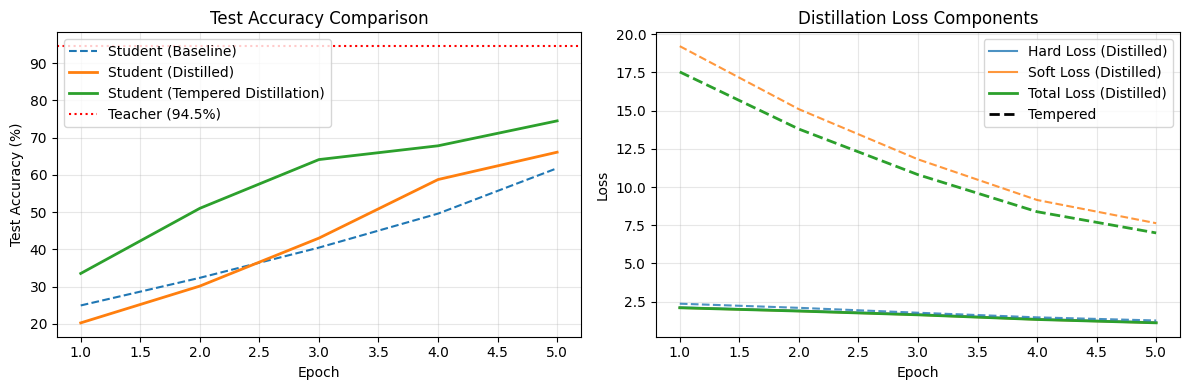

In [27]:
#@title Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Test accuracy comparison (axes[0] remains as is, it already has distinct labels and lines)
xs = np.arange(1, STUDENT_EPOCHS + 1)
axes[0].plot(xs, baseline_history['test_acc'], label='Student (Baseline)', linestyle='--')
axes[0].plot(xs, distilled_history['test_acc'], label='Student (Distilled)', linewidth=2)
axes[0].plot(xs, tempered_distillation_history['test_acc'], label='Student (Tempered Distillation)', linewidth=2)
axes[0].axhline(y=teacher_acc, color='r', linestyle=':', label=f'Teacher ({teacher_acc:.1f}%)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('Test Accuracy Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss breakdown for distilled student (axes[1])
# Define consistent colors for the loss components
hard_loss_color = 'tab:blue'
soft_loss_color = 'tab:orange'
total_loss_color = 'tab:green'

# Plot original distillation losses with solid lines
axes[1].plot(xs, distilled_history['hard_loss'], label='Hard Loss (Distilled)', alpha=0.8, color=hard_loss_color)
axes[1].plot(xs, distilled_history['soft_loss'], label='Soft Loss (Distilled)', alpha=0.8, color=soft_loss_color)
axes[1].plot(xs, distilled_history['total_loss'], label='Total Loss (Distilled)', linewidth=2, color=total_loss_color)

# Plot tempered distillation losses with dashed lines and the same colors
axes[1].plot(xs, tempered_distillation_history['hard_loss'], alpha=0.8, color=hard_loss_color, linestyle='--')
axes[1].plot(xs, tempered_distillation_history['soft_loss'], alpha=0.8, color=soft_loss_color, linestyle='--')
axes[1].plot(xs, tempered_distillation_history['total_loss'], linewidth=2, color=total_loss_color, linestyle='--')
axes[1].plot([], [], linewidth=2, linestyle='--', c='k', label='Tempered')

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Distillation Loss Components')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Born Again Networks (Use the previous trained model (Student) as a Teacher).

In [ ]:
# Distillation configuration
STUDENT_EPOCHS = 30
TEMPERATURE = 4.0  # Try: 2, 4, 8, 20
ALPHA = 0.1        # Weight for hard loss (try: 0.1, 0.3, 0.5)
LR = 0.01

# Load trained teacher
teacher_dim = teacher.fc.in_features
teacher_st_baseline = StudentCNN(output_dim=teacher_dim).to(device)
teacher_st_baseline.load_state_dict(torch.load('student_baseline.pth'))
teacher_st_baseline.eval()

student_distilled = StudentCNN(output_dim=teacher_dim).to(device)

# Setup training
distill_criterion = DistillationLoss(temperature=TEMPERATURE, alpha=ALPHA)
optimizer = optim.Adam(student_distilled.parameters(), lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STUDENT_EPOCHS, eta_min=0.001)

print(f"Training Student with Knowledge Distillation")
print(f"Temperature: {TEMPERATURE}, Alpha: {ALPHA}")
print("=" * 60)

distilled_history = {'total_loss': [], 'hard_loss': [], 'soft_loss': [], 'train_acc': [], 'test_acc': []}

best_test_acc = 0.0
for epoch in range(STUDENT_EPOCHS):
    total_loss, hard_loss, soft_loss, train_acc = train_with_distillation(
        student_distilled, teacher_st_baseline, trainloader, distill_criterion, optimizer, device
    )
    test_acc = evaluate(student_distilled, testloader, device)
    scheduler.step()

    distilled_history['total_loss'].append(total_loss)
    distilled_history['hard_loss'].append(hard_loss)
    distilled_history['soft_loss'].append(soft_loss)
    distilled_history['train_acc'].append(train_acc)
    distilled_history['test_acc'].append(test_acc)

    print(f"Epoch {epoch+1:2d}/{STUDENT_EPOCHS} | Loss: {total_loss:.4f} (H:{hard_loss:.3f} S:{soft_loss:.3f}) | "
          f"Train: {train_acc:.2f}% | Test: {test_acc:.2f}%")

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(student_distilled.state_dict(), 'student_distilled_v2.pth')
print(f"\n✅ Distilled Student final test accuracy: {best_test_acc:.2f}%")

Training Student with Knowledge Distillation
Temperature: 4.0, Alpha: 0.1


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  1/30 | Loss: 10.1360 (H:2.254 S:11.012) | Train: 19.68% | Test: 32.64%


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  2/30 | Loss: 7.6772 (H:1.938 S:8.315) | Train: 33.15% | Test: 37.59%


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  3/30 | Loss: 5.7288 (H:1.638 S:6.183) | Train: 47.52% | Test: 55.62%


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  4/30 | Loss: 4.0338 (H:1.328 S:4.335) | Train: 60.42% | Test: 67.29%


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  5/30 | Loss: 3.1846 (H:1.143 S:3.412) | Train: 66.52% | Test: 65.96%


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  6/30 | Loss: 2.6878 (H:1.001 S:2.875) | Train: 70.57% | Test: 73.08%


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  7/30 | Loss: 2.3689 (H:0.912 S:2.531) | Train: 72.94% | Test: 75.75%


Distilling:   0%|          | 0/391 [00:00<?, ?it/s]

## 14. 🧪 Experiment: Hyperparameter Sensitivity

Try different values of **Temperature** and **Alpha** to see their effects!

In [ ]:
def quick_distillation_experiment(temperature, alpha, epochs=15):
    """Quick experiment with different hyperparameters"""
    student = StudentCNN().to(device)
    criterion = DistillationLoss(temperature=temperature, alpha=alpha)
    optimizer = optim.Adam(student.parameters(), lr=0.001)

    for epoch in range(epochs):
        train_with_distillation(student, teacher, trainloader, criterion, optimizer, device)

    return evaluate(student, testloader, device)

# Uncomment to run experiments (takes a few minutes)
# print("Running hyperparameter experiments...")

# temperatures = [1, 2, 4, 8, 16]
# alphas = [0.1, 0.3, 0.5, 0.7]

# results = {}
# for T in temperatures:
#     for a in alphas:
#         acc = quick_distillation_experiment(T, a)
#         results[(T, a)] = acc
#         print(f"T={T}, α={a}: {acc:.2f}%")

## 15. Types of Knowledge Distillation

What we implemented is **Response-based Distillation**. There are other types:

| Type | What's Transferred | Example |
|------|-------------------|--------|
| **Response-based** | Final output logits | What we did! |
| **Feature-based** | Intermediate representations | FitNets, Attention Transfer |
| **Relation-based** | Relationships between samples | Contrastive distillation |

### Bonus: Feature-based Distillation (FitNets)

The idea is to also match intermediate feature maps, not just outputs.

In [ ]:
class FeatureDistillationLoss(nn.Module):
    """
    Feature-based distillation: match intermediate representations.
    Requires a projection layer if dimensions don't match.
    """
    def __init__(self, device, student_dim, teacher_dim, temperature=4.0, alpha=0.3, beta=0.5):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.beta = beta  # Weight for feature loss

        # Projection layer if dimensions don't match
        self.projector = nn.Linear(student_dim, teacher_dim) if student_dim != teacher_dim else nn.Identity()
        self.projector = self.projector.to(device)

        self.ce_loss = nn.CrossEntropyLoss()
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')
        self.mse_loss = nn.MSELoss()

    def forward(self, student_logits, teacher_logits, student_features, teacher_features, labels):
        # Standard distillation losses
        hard_loss = self.ce_loss(student_logits, labels)
        soft_loss = self.kl_loss(
            F.log_softmax(student_logits / self.temperature, dim=1),
            F.softmax(teacher_logits / self.temperature, dim=1)
        ) * (self.temperature ** 2)

        # Feature matching loss
        student_proj = self.projector(student_features)
        feature_loss = 1 - F.cosine_similarity(student_proj, teacher_features).mean()

        # Combined loss
        total = self.alpha * hard_loss + (1 - self.alpha - self.beta) * soft_loss + self.beta * 10 * feature_loss

        return total, hard_loss, soft_loss, feature_loss

In [ ]:
def train_with_feature_distillation(student, teacher, trainloader, criterion, optimizer, device):
    """
    Train student using knowledge distillation from teacher.
    Teacher is frozen (no gradients).
    """
    student.train()
    teacher.eval()  # Teacher is always in eval mode

    running_loss = 0.0
    running_hard_loss = 0.0
    running_soft_loss = 0.0
    running_feature_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(trainloader, desc="Distilling", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # Get teacher predictions (no gradient needed)
        with torch.no_grad():
            teacher_logits, teacher_features = teacher(inputs, output_features=True)

        # Forward pass for student
        optimizer.zero_grad()
        student_logits, student_features = student(inputs, output_features=True)

        # Compute distillation loss
        loss, hard_loss, soft_loss, feature_loss = criterion(student_logits, teacher_logits, student_features, teacher_features, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        running_hard_loss += hard_loss.item()
        running_soft_loss += soft_loss.item()
        running_feature_loss += feature_loss.item()
        _, predicted = student_logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    n = len(trainloader)
    return running_loss/n, running_hard_loss/n, running_soft_loss/n, running_feature_loss/n, 100.*correct/total

In [ ]:
# Distillation configuration
STUDENT_EPOCHS = 30
TEMPERATURE = 4.0  # Try: 2, 4, 8, 20
ALPHA = 0.1        # Weight for hard loss (try: 0.1, 0.3, 0.5)
LR = 0.01
BETA = 0.5

# Load trained teacher
teacher.load_state_dict(torch.load('teacher_resnet18.pth'))
teacher.eval()

# Create fresh student
teacher_dim = teacher.fc.in_features
student_distilled = StudentCNN(output_dim=teacher_dim).to(device)

# Setup training
student_dim = student_distilled.fc2[1].in_features
teacher_dim = teacher.fc.in_features
distill_criterion = FeatureDistillationLoss(device, student_dim, teacher_dim, temperature=TEMPERATURE, alpha=ALPHA, beta=BETA)
parameters = list(student_distilled.parameters()) + list(distill_criterion.projector.parameters())
optimizer = optim.Adam(parameters, lr=LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STUDENT_EPOCHS, eta_min=0.001)

print(f"Training Student with Knowledge Distillation")
print(f"Temperature: {TEMPERATURE}, Alpha: {ALPHA}, Beta: {BETA}")
print("=" * 60)

distilled_history = {'total_loss': [], 'hard_loss': [], 'soft_loss': [], 'feature_loss': [],'train_acc': [], 'test_acc': []}

for epoch in range(STUDENT_EPOCHS):
    total_loss, hard_loss, soft_loss, feature_loss, train_acc = train_with_feature_distillation(
        student_distilled, teacher, trainloader, distill_criterion, optimizer, device
    )
    test_acc = evaluate(student_distilled, testloader, device)
    scheduler.step()

    distilled_history['total_loss'].append(total_loss)
    distilled_history['hard_loss'].append(hard_loss)
    distilled_history['soft_loss'].append(soft_loss)
    distilled_history['feature_loss'].append(feature_loss)
    distilled_history['train_acc'].append(train_acc)
    distilled_history['test_acc'].append(test_acc)

    print(f"Epoch {epoch+1:2d}/{STUDENT_EPOCHS} | Loss: {total_loss:.4f} (H:{hard_loss:.3f} S:{soft_loss:.3f} F:{feature_loss:.3f}) | "
          f"Train: {train_acc:.2f}% | Test: {test_acc:.2f}%")

print(f"\n✅ Distilled Student final test accuracy: {test_acc:.2f}%")

## 16. Key Takeaways

### ✅ What We Learned

1. **Knowledge Distillation** transfers "dark knowledge" from a large teacher to a small student

2. **Soft labels** contain richer information than hard labels (class relationships)

3. **Temperature** controls how soft the probability distribution is:
   - Higher T = more information transfer, but potentially noisier
   - Typical values: 2-20

4. **Alpha** balances hard and soft losses:
   - Lower α = more emphasis on mimicking teacher
   - Higher α = more emphasis on ground truth

5. **Results**: Distilled students typically outperform students trained from scratch by 1-5%

### 🚀 Extensions to Explore

- **Self-distillation**: Use the same architecture for teacher and student
- **Online distillation**: Train teacher and student simultaneously
- **Multi-teacher distillation**: Ensemble of teachers
- **Task-specific distillation**: For NLP, use DistilBERT approach

### 📚 References

1. Hinton et al., "Distilling the Knowledge in a Neural Network" (2015)
2. Romero et al., "FitNets: Hints for Thin Deep Nets" (2015)
3. Gou et al., "Knowledge Distillation: A Survey" (2021)

## 15. 💪 Exercise for You!

Try these modifications and see what happens:

1. **Change the student architecture**: Make it deeper or wider
2. **Try different temperatures**: Plot accuracy vs temperature

In [ ]:
# Your experiments here!
#
# Example: Try a deeper student
# class DeeperStudent(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Your architecture here
#         pass